# Latest script - Sep 24

In [30]:
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from collections import Counter  # to count class labels distribution

In [3]:
# Load the cluster distribution data
# Load the cluster distribution data
cluster_distribution = '/Users/psenevirathn/Desktop/PhD/Coding/Trajectories/Results_from_HPC/full_results_only_with_TP_and_TN/June21_only_TP_and_TN/EventLogV1_noise0.3_fitness0.6/cluster_distribution_LogV1_Noise0.3_Fitness0.6.csv'
cluster_distribution_df = pd.read_csv(cluster_distribution)

clusters_in_hadmid_level = '/Users/psenevirathn/Desktop/PhD/Coding/Trajectories/Results_from_HPC/full_results_only_with_TP_and_TN/June21_only_TP_and_TN/EventLogV1_noise0.3_fitness0.6/clusters_hadm_id_level_LogV1_Noise0.3_Fitness0.6.csv'
clusters_in_hadmid_level_df = pd.read_csv(clusters_in_hadmid_level)

In [4]:
print(clusters_in_hadmid_level_df['hadm_id'].nunique()) # 12341
print(clusters_in_hadmid_level_df[clusters_in_hadmid_level_df['class'] == 'TP']['hadm_id'].nunique()) # 1053
print(clusters_in_hadmid_level_df[clusters_in_hadmid_level_df['class'] == 'TN']['hadm_id'].nunique()) # 11288

print(cluster_distribution_df['cluster_index'].max()+1) # cluster count - 13

12341
1053
11288
13


In [5]:
# remove clusters with few patients

cluster_distribution_df_after_removing_outliers= cluster_distribution_df[cluster_distribution_df['patient_count'] > 5] # check this

In [23]:
# Full event log (which includes

event_log_full_with_adm_and_dischge = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Trajectories/Input/Input_for_clustering/May15_v1.csv') # hadm_id count - 13415

event_log_full_with_adm_and_dischge['event_time'] = pd.to_datetime(event_log_full_with_adm_and_dischge['event_time'])

In [24]:
Counter((event_log_full_with_adm_and_dischge[['hadm_id', 'HIT_label']].drop_duplicates())['HIT_label'])

Counter({0: 11426, 1: 1989})

In [16]:
clusters_in_hadmid_level_df

In [116]:
# To avoid FP and FN patients, join as below, then event logs for only TP and TN will be considered.
# clusters_in_hadmid_level_df - this only contain TP and TN patients

event_log_with_cluster_distribution = pd.merge(clusters_in_hadmid_level_df, event_log_full_with_adm_and_dischge, how='left', on='hadm_id') # hadm_id count = 12341

# 1. Deciding a Baseline TP:TN

# 1.1 Deciding a Baseline TP:TN - Thrombotic events

In [117]:
# check thrombotic count in each cluster

Thrombotic_events_hadm_id_and_cluster_index = event_log_with_cluster_distribution[event_log_with_cluster_distribution['event']=='First_Thrombosis_or_Embolism'][['hadm_id', 'cluster_index']].drop_duplicates()

# Group by 'cluster_index' and count occurrences of thrombotic events
count_data = Thrombotic_events_hadm_id_and_cluster_index.groupby('cluster_index').size().reset_index(name='count_Thrombotic_events')

# merge thrombotic event count of each cluster with more information of clusters (like TP percentage and patient count in each cluster)
thrombotic_event_count_in_each_cluster_with_more_cluster_info = pd.merge(cluster_distribution_df_after_removing_outliers, count_data, how='left', on='cluster_index')


# add a new column - thrombotic event percentage in each cluster 

thrombotic_event_count_in_each_cluster_with_more_cluster_info['Thromb_per'] = thrombotic_event_count_in_each_cluster_with_more_cluster_info['count_Thrombotic_events'] / thrombotic_event_count_in_each_cluster_with_more_cluster_info['patient_count']*100

# rename columns appropriately

thrombotic_event_count_in_each_cluster_with_more_cluster_info.rename(columns={'TP%': 'TP_percentage', 'TN%': 'TN_percentage'}, inplace=True)

#select only required columns and sort by 'TP%' from lowest to highest
Thromp_per_with_TP_per_in_clusters = thrombotic_event_count_in_each_cluster_with_more_cluster_info[['cluster_index','patient_count', 'TP_count', 'TN_count', 'TP_percentage', 'TN_percentage', 'count_Thrombotic_events', 'Thromb_per']].sort_values(by='TP_percentage', ascending=True)

In [118]:
# Add a new column which contains how many thrombotic patients in each cluster for TP and TN classes separately.

# Group by 'cluster_index' and 'class', and count occurrences
# The data is grouped by cluster_index and class, where class can either be 'TP' or 'TN'.
# The .size() function is used to count the occurrences of each class within each cluster
# The .unstack(fill_value=0) operation pivots the grouped data so that class values (TP and TN) become separate columns.
# The fill_value=0 ensures that if a cluster has no instances of either TP or TN, the count will be represented as 0.

Thrombotic_events_count_of_each_cluster_class_wise = event_log_with_cluster_distribution[event_log_with_cluster_distribution['event']=='First_Thrombosis_or_Embolism'] \
    .groupby(['cluster_index', 'class']) \
    .size() \
    .unstack(fill_value=0) \
    .reset_index()

# Explicitly reorder columns to ensure 'TN' is first and 'TP' is second (to rename properly, in next line)
Thrombotic_events_count_of_each_cluster_class_wise = Thrombotic_events_count_of_each_cluster_class_wise[['cluster_index', 'TN', 'TP']]

# Rename the columns for clarity
Thrombotic_events_count_of_each_cluster_class_wise.columns = ['cluster_index', 'TN_Thrombotic_events_count', 'TP_Thrombotic_events_count']

# Display the result
Thrombotic_events_count_of_each_cluster_class_wise.reset_index()

# left join - only to filter the clusters without outliers
Thrombotic_events_count_of_each_cluster_class_wise = pd.merge(Thromp_per_with_TP_per_in_clusters, Thrombotic_events_count_of_each_cluster_class_wise, how='left', on='cluster_index')
Thrombotic_events_count_of_each_cluster_class_wise

,cluster_index,patient_count,TP_count,TN_count,TP_percentage,TN_percentage,count_Thrombotic_events,Thromb_per,TN_Thrombotic_events_count,TP_Thrombotic_events_count
0,0,4461,40,4421,0.896660,99.103340,1201,26.922215,1182,19
1,1,746,36,710,4.825737,95.174263,357,47.855228,339,18
2,2,1028,59,969,5.739300,94.260700,355,34.533074,331,24
3,5,710,49,661,6.901408,93.098592,408,57.464789,372,36
4,3,2878,216,2662,7.505212,92.494788,1284,44.614315,1140,144
5,4,347,60,287,17.291066,82.708934,236,68.011527,189,47
6,7,577,102,475,17.677643,82.322357,408,70.710572,323,85
7,10,1588,489,1099,30.793451,69.206549,1308,82.367758,857,451


In [119]:
# Method : cumulative upto current (including) cluster vs cumulative in remaining cluster

#Sort the DataFrame by 'TP_percentage' in ascending order
df = Thrombotic_events_count_of_each_cluster_class_wise.sort_values(by='TP_percentage').reset_index(drop=True)

# Initialize lists to store results

current_group_patient_count_list = []
current_group_Thrombotic_events_count_list = []
remaining_group_patient_count_list = []
remaining_group_Thrombotic_events_count_list = []
cumulative_TP_Thrombotic_events_count_per_list = []

p_values = []

# Iterate through each row in the DataFrame
for i in range(len(df)): # for i in range(8) = 0,1,2,..,7 = 8 clusters , len(df) = 8
    # Current Group (up to and including the current row)
    
    if i + 1 < len(df):

        current_group_total_patient_count = df.loc[:i, 'patient_count'].sum()     
        current_group_total_Thrombotic_events_count = df.loc[:i, 'count_Thrombotic_events'].sum()

        remaining_group_total_patient_count = df.loc[i+1:, 'patient_count'].sum()     
        remaining_group_total_Thrombotic_events_count = df.loc[i+1:, 'count_Thrombotic_events'].sum()
    
    # Observed counts
        observed = np.array([
                [current_group_total_Thrombotic_events_count, current_group_total_patient_count - current_group_total_Thrombotic_events_count],
                [remaining_group_total_Thrombotic_events_count, remaining_group_total_patient_count - remaining_group_total_Thrombotic_events_count]
            ])

        # Contingency table should be like below.

        #[cumulative thrombotic events inclusive current cluster, cumulative Non-thrombotic events inclusive current cluster],
        #[Remaining thrombotic events after current cluster, Remaining Non-thrombotic events after current cluster]

                
    # 
    # Perform Chi-squared test
        chi2_stat, p_value, dof, expected = chi2_contingency(observed)
    
    else:  # When i = last cluster, no more remaining clusters left (current cluster falls into 'current group')
        current_group_patient_count = df.loc[:i, 'TP_count'].sum() 
        current_group_Thrombotic_events_count = df.loc[:i, 'TP_Thrombotic_events_count'].sum()

        # No remaining group
        remaining_group_patient_count = 0
        remaining_group_Thrombotic_events_count = 0 

        observed = np.array([
                [current_group_Thrombotic_events_count, current_group_patient_count],
                [remaining_group_Thrombotic_events_count, remaining_group_patient_count]
            ])
        
        # Assign p_value as NaN or any placeholder value since there's no comparison to make
        p_value = np.nan

    # Store p-value
    
    current_group_patient_count_list.append(current_group_total_patient_count)
    current_group_Thrombotic_events_count_list.append(current_group_total_Thrombotic_events_count)
    remaining_group_patient_count_list.append(remaining_group_total_patient_count)
    remaining_group_Thrombotic_events_count_list.append(remaining_group_total_Thrombotic_events_count)
    
    cumulative_TP_Thrombotic_events_count_per_list.append(remaining_group_total_Thrombotic_events_count/current_group_total_patient_count*100)
        
    p_values.append(p_value)

    print(i)
    print(observed)
    print(expected)
    print(p_value)
    print('\n')
    
df['current_group_patient_count'] = current_group_patient_count_list
df['current_group_Thrombotic_events_count'] = current_group_Thrombotic_events_count_list
df['remaining_group_patient_count'] = remaining_group_patient_count_list
df['remaining_group_Thrombotic_events_count'] = remaining_group_Thrombotic_events_count_list

df['p_value'] = p_values

df['TP_Thrombotic_events_count_per'] = df['TP_Thrombotic_events_count']/df['TP_count']*100

df['TP_Thrombotic_events_count_per_from_full_Thrombotic_events_in_cluster'] = df['TP_Thrombotic_events_count']/df['count_Thrombotic_events']*100

#df['cumulative_TP_Thrombotic_events_count_per'] = cumulative_TP_Mortality_count_per_list
df

0
[[1201 3260]
 [4356 3518]]
[[2009.71033644 2451.28966356]
 [3547.28966356 4326.71033644]]
1.6120016315953547e-203


1
[[1558 3649]
 [3999 3129]]
[[2345.7883259 2861.2116741]
 [3211.2116741 3916.7883259]]
5.5972595577952234e-183


2
[[1913 4322]
 [3644 2456]]
[[2808.90920146 3426.09079854]
 [2748.09079854 3351.90920146]]
1.9982501939489755e-230


3
[[2321 4624]
 [3236 2154]]
[[3128.76895014 3816.23104986]
 [2428.23104986 2961.76895014]]
1.1617391063760367e-190


4
[[3605 6218]
 [1952  560]]
[[4425.32719903 5397.67280097]
 [1131.67280097 1380.32719903]]
4.116840535140276e-297


5
[[3841 6329]
 [1716  449]]
[[4581.65301986 5588.34698014]
 [ 975.34698014 1189.65301986]]
1.3905347309682958e-271


6
[[4249 6498]
 [1308  280]]
[[4841.595379 5905.404621]
 [ 715.404621  872.595379]]
1.3466013412289776e-224


7
[[ 824 1051]
 [   0    0]]
[[4841.595379 5905.404621]
 [ 715.404621  872.595379]]
nan




,cluster_index,patient_count,TP_count,TN_count,TP_percentage,TN_percentage,count_Thrombotic_events,Thromb_per,TN_Thrombotic_events_count,TP_Thrombotic_events_count,current_group_patient_count,current_group_Thrombotic_events_count,remaining_group_patient_count,remaining_group_Thrombotic_events_count,p_value,TP_Thrombotic_events_count_per,TP_Thrombotic_events_count_per_from_full_Thrombotic_events_in_cluster
0,0,4461,40,4421,0.896660,99.103340,1201,26.922215,1182,19,4461,1201,7874,4356,1.612002e-203,47.500000,1.582015
1,1,746,36,710,4.825737,95.174263,357,47.855228,339,18,5207,1558,7128,3999,5.597260e-183,50.000000,5.042017
2,2,1028,59,969,5.739300,94.260700,355,34.533074,331,24,6235,1913,6100,3644,1.998250e-230,40.677966,6.760563
3,5,710,49,661,6.901408,93.098592,408,57.464789,372,36,6945,2321,5390,3236,1.161739e-190,73.469388,8.823529
4,3,2878,216,2662,7.505212,92.494788,1284,44.614315,1140,144,9823,3605,2512,1952,4.116841e-297,66.666667,11.214953
5,4,347,60,287,17.291066,82.708934,236,68.011527,189,47,10170,3841,2165,1716,1.390535e-271,78.333333,19.915254
6,7,577,102,475,17.677643,82.322357,408,70.710572,323,85,10747,4249,1588,1308,1.346601e-224,83.333333,20.833333
7,10,1588,489,1099,30.793451,69.206549,1308,82.367758,857,451,10747,4249,1588,1308,NaN,92.229039,34.480122


# 1.2 Deciding a Baseline TP:TN - Mortality

In [120]:
Mortality_events_hadm_id_and_cluster_index = event_log_with_cluster_distribution[event_log_with_cluster_distribution['event']=='hospital_expire_flag_1'][['hadm_id', 'cluster_index']].drop_duplicates()

# Group by 'cluster_index' and count occurrences of thrombotic events
count_data_Mortality = Mortality_events_hadm_id_and_cluster_index.groupby('cluster_index').size().reset_index(name='count_Mortality')

# merge thrombotic event count of each cluster with more information of clusters (like TP percentage and patient count in each cluster)
Mortality_event_count_in_each_cluster_with_more_cluster_info = pd.merge(cluster_distribution_df_after_removing_outliers, count_data_Mortality, how='left', on='cluster_index')

# add thrombotic event percentage in each cluster 
Mortality_event_count_in_each_cluster_with_more_cluster_info['Mortality_per'] = Mortality_event_count_in_each_cluster_with_more_cluster_info['count_Mortality'] / Mortality_event_count_in_each_cluster_with_more_cluster_info['patient_count']*100

# rename columns appropriately
Mortality_event_count_in_each_cluster_with_more_cluster_info.rename(columns={'TP%': 'TP_percentage', 'TN%': 'TN_percentage'}, inplace=True)

#select only required columns
Mortality_per_with_TP_per_in_clusters = Mortality_event_count_in_each_cluster_with_more_cluster_info[['cluster_index','patient_count', 'TP_count', 'TN_count', 'TP_percentage', 'TN_percentage', 'count_Mortality', 'Mortality_per']].sort_values(by='TP_percentage', ascending=True)

In [121]:
# Add a new column which contains how many patients died in each cluster for TP and TN classes separately.

Mortality_count_of_each_cluster_class_wise = event_log_with_cluster_distribution[event_log_with_cluster_distribution['event']=='hospital_expire_flag_1'] \
    .groupby(['cluster_index', 'class']) \
    .size() \
    .unstack(fill_value=0) \
    .reset_index()

# Explicitly reorder columns to ensure 'TN' is first and 'TP' is second (to rename properly, in next line)
Mortality_count_of_each_cluster_class_wise = Mortality_count_of_each_cluster_class_wise[['cluster_index', 'TN', 'TP']]

# Rename the columns for clarity
Mortality_count_of_each_cluster_class_wise.columns = ['cluster_index', 'TN_Mortality_count', 'TP_Mortality_count']

# Display the result
Mortality_count_of_each_cluster_class_wise.reset_index()

Mortality_each_cluster_class_wise = pd.merge(Mortality_per_with_TP_per_in_clusters, Mortality_count_of_each_cluster_class_wise, how='left', on='cluster_index')
Mortality_each_cluster_class_wise


,cluster_index,patient_count,TP_count,TN_count,TP_percentage,TN_percentage,count_Mortality,Mortality_per,TN_Mortality_count,TP_Mortality_count
0,0,4461,40,4421,0.896660,99.103340,77,1.726070,77,0
1,1,746,36,710,4.825737,95.174263,68,9.115282,64,4
2,2,1028,59,969,5.739300,94.260700,63,6.128405,59,4
3,5,710,49,661,6.901408,93.098592,92,12.957746,80,12
4,3,2878,216,2662,7.505212,92.494788,311,10.806115,283,28
5,4,347,60,287,17.291066,82.708934,61,17.579251,44,17
6,7,577,102,475,17.677643,82.322357,95,16.464471,64,31
7,10,1588,489,1099,30.793451,69.206549,313,19.710327,173,140


In [122]:
# Method: cumulative upto current (including) cluster vs cumulative in remaining cluster

# Step 1: Sort the DataFrame by 'TP_percentage' in ascending order
df = Mortality_each_cluster_class_wise.sort_values(by='TP_percentage').reset_index(drop=True)

# Initialize lists to store results

current_group_patient_count_list = []
current_group_Mortality_count_list = []
remaining_group_patient_count_list = []
remaining_group_Mortality_count_list = []
cumulative_TP_Mortality_count_per_list = []

p_values = []

# Iterate through each row in the DataFrame
for i in range(len(df)): # for i in range(8) = 0,1,2,..,7 = 8 clusters , len(df) = 8
    # Current Group (up to and including the current row)
    
    if i + 1 < len(df):

        current_group_total_patient_count = df.loc[:i, 'patient_count'].sum()     
        current_group_total_Mortality_count = df.loc[:i, 'count_Mortality'].sum()
        
        current_group_TP_patient_count = df.loc[:i, 'TP_count'].sum() 
        current_group_TP_Mortality_count = df.loc[:i, 'TP_Mortality_count'].sum()


        remaining_group_total_patient_count = df.loc[i+1:, 'patient_count'].sum()     
        remaining_group_total_Mortality_count = df.loc[i+1:, 'count_Mortality'].sum()
        
        remaining_group_TP_patient_count = df.loc[i+1:, 'TP_count'].sum() 
        remaining_group_TP_Mortality_count = df.loc[i+1:, 'TP_Mortality_count'].sum()
    
    # Observed counts
        observed = np.array([
                [current_group_total_Mortality_count, current_group_total_patient_count - current_group_total_Mortality_count],
                [remaining_group_total_Mortality_count, remaining_group_total_patient_count - remaining_group_total_Mortality_count]
            ])

        # Contingency table should be like below.

        #[cumulative thrombotic events inclusive current cluster, cumulative Non-thrombotic events inclusive current cluster],
        #[Remaining thrombotic events after current cluster, Remaining Non-thrombotic events after current cluster]

                
    # 
    # Perform Chi-squared test
        chi2_stat, p_value, dof, expected = chi2_contingency(observed)
    
    else:  # When i = last cluster, no more remaining clusters left (current cluster falls into 'current group')
        current_group_patient_count = df.loc[:i, 'TP_count'].sum() 
        current_group_Mortality_count = df.loc[:i, 'TP_Mortality_count'].sum()

        # No remaining group
        remaining_group_patient_count = 0
        remaining_group_Mortality_count = 0 

        observed = np.array([
                [current_group_Mortality_count, current_group_patient_count],
                [remaining_group_Mortality_count, remaining_group_patient_count]
            ])
        
        # Assign p_value as NaN or any placeholder value since there's no comparison to make
        p_value = np.nan

    # Store p-value
    
    #current_group_patient_count_list.append(current_group_patient_count)
    #current_group_Mortality_count_list.append(current_group_Mortality_count)
    #remaining_group_patient_count_list.append(remaining_group_patient_count)
    #remaining_group_Mortality_count_list.append(remaining_group_Mortality_count)
    
    #cumulative_TP_Mortality_count_per_list.append(current_group_Mortality_count/current_group_patient_count*100)
        
    p_values.append(p_value)

    print(i)
    print(observed)
    print(expected)
    print(p_value)
    print('\n')
    
#df['current_group_patient_count'] = current_group_patient_count_list
#df['current_group_Mortality_count'] = current_group_Mortality_count_list
#df['remaining_group_patient_count'] = remaining_group_patient_count_list
#df['remaining_group_Mortality_count'] = remaining_group_Mortality_count_list

df['p_value'] = p_values

df['TP_Mortality_count_per'] = df['TP_Mortality_count']/df['TP_count']*100

df['TP_Mortality_count_per_from_full_mortality_in_cluster'] = df['TP_Mortality_count']/df['count_Mortality']*100

#df['cumulative_TP_Mortality_count_per'] = cumulative_TP_Mortality_count_per_list
df


0
[[  77 4384]
 [1003 6871]]
[[ 390.58613701 4070.41386299]
 [ 689.41386299 7184.58613701]]
1.0497909191486644e-95


1
[[ 145 5062]
 [ 935 6193]]
[[ 455.90271585 4751.09728415]
 [ 624.09728415 6503.90271585]]
3.6603321941440924e-89


2
[[ 208 6027]
 [ 872 5228]]
[[ 545.91001216 5689.08998784]
 [ 534.08998784 5565.91001216]]
1.6239359082895682e-102


3
[[ 300 6645]
 [ 780 4610]]
[[ 608.07458452 6336.92541548]
 [ 471.92541548 4918.07458452]]
7.484744439825256e-87


4
[[ 611 9212]
 [ 469 2043]]
[[ 860.05999189 8962.94000811]
 [ 219.94000811 2292.05999189]]
4.5811096239475176e-86


5
[[ 672 9498]
 [ 408 1757]]
[[ 890.44183218 9279.55816782]
 [ 189.55816782 1975.44183218]]
2.049442607715307e-74


6
[[ 767 9980]
 [ 313 1275]]
[[ 940.96149169 9806.03850831]
 [ 139.03850831 1448.96149169]]
3.728583047792701e-61


7
[[ 236 1051]
 [   0    0]]
[[ 940.96149169 9806.03850831]
 [ 139.03850831 1448.96149169]]
nan




,cluster_index,patient_count,TP_count,TN_count,TP_percentage,TN_percentage,count_Mortality,Mortality_per,TN_Mortality_count,TP_Mortality_count,p_value,TP_Mortality_count_per,TP_Mortality_count_per_from_full_mortality_in_cluster
0,0,4461,40,4421,0.896660,99.103340,77,1.726070,77,0,1.049791e-95,0.000000,0.000000
1,1,746,36,710,4.825737,95.174263,68,9.115282,64,4,3.660332e-89,11.111111,5.882353
2,2,1028,59,969,5.739300,94.260700,63,6.128405,59,4,1.623936e-102,6.779661,6.349206
3,5,710,49,661,6.901408,93.098592,92,12.957746,80,12,7.484744e-87,24.489796,13.043478
4,3,2878,216,2662,7.505212,92.494788,311,10.806115,283,28,4.581110e-86,12.962963,9.003215
5,4,347,60,287,17.291066,82.708934,61,17.579251,44,17,2.049443e-74,28.333333,27.868852
6,7,577,102,475,17.677643,82.322357,95,16.464471,64,31,3.728583e-61,30.392157,32.631579
7,10,1588,489,1099,30.793451,69.206549,313,19.710327,173,140,NaN,28.629857,44.728435


# 2. Calculate OD cases with new baseline distribution

In [123]:
NEW_overall_positive_ratio = 0.075
NEW_overall_negative_ratio = 1-NEW_overall_positive_ratio

In [124]:
# Significance level
alpha = 0.05

# Step 2: Perform Chi-Squared Test for each cluster
OD_NonOD_results = []

for _, row in cluster_distribution_df.iterrows(): # cluster_distribution_df-consider all records (event the outliers)
    cluster_index = row['cluster_index']
    observed_TN = row['TN_count']
    observed_TP = row['TP_count']
    total_cluster_patients = row['patient_count']
    #patient_count = row['patient_count']
    # Expected counts based on overall ratios
    expected_TN = NEW_overall_negative_ratio * total_cluster_patients
    expected_TP = NEW_overall_positive_ratio * total_cluster_patients

    # Perform chi-squared test
    observed = [observed_TN, observed_TP]
    expected = [expected_TN, expected_TP]

    # chi2_contingency expects frequencies in a 2x2 table format
    contingency_table = [observed, expected]
    
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    significant = p_value < alpha
    
    # first condition inside 'if' to overcome zero division error when observed_TN = 0
        
    majority_class = 'TP' if (observed_TN == 0 or observed_TP >= expected_TP) else 'TN'
    
    #majority_class = 'TP' if (observed_TP/observed_TN > TP_to_TN_ratio) else 'TN'
    significant_majority_class = f'True_{majority_class}' if significant else 'False'


    OD_NonOD_results.append({
        'cluster_index': int(cluster_index),
        'patient_count': int(total_cluster_patients),
        'TP_count': int(observed_TP),
        'TN_count': int(observed_TN),
        
        'Expected_TP_count': int(expected_TP),
        'Expected_TN_count': int(expected_TN),
        
        'TP_percentage': round((observed_TP / total_cluster_patients) * 100, 2),
        'TN_percentage': round((observed_TN / total_cluster_patients) * 100, 2),
        
        'chi2_statistic': round(chi2, 2),
        'p_value': round(p_value, 2),
        'significant': significant,
        'significant_majority_class': significant_majority_class

    })

# Convert results to DataFrame
OD_NonOD_results_df = pd.DataFrame(OD_NonOD_results).sort_values(by='TP_percentage').reset_index(drop=True)
OD_NonOD_results_df

,cluster_index,patient_count,TP_count,TN_count,Expected_TP_count,Expected_TN_count,TP_percentage,TN_percentage,chi2_statistic,p_value,significant,significant_majority_class
0,6,1,0,1,0,0,0.00,100.00,0.00,1.00,False,False
1,9,2,0,2,0,1,0.00,100.00,0.00,1.00,False,False
2,11,1,0,1,0,0,0.00,100.00,0.00,1.00,False,False
3,0,4461,40,4421,334,4126,0.90,99.10,240.17,0.00,True,True_TN
4,1,746,36,710,55,690,4.83,95.17,4.16,0.04,True,True_TN
5,2,1028,59,969,77,950,5.74,94.26,2.30,0.13,False,False
6,5,710,49,661,53,656,6.90,93.10,0.11,0.74,False,False
7,3,2878,216,2662,215,2662,7.51,92.49,0.00,1.00,False,False
8,4,347,60,287,26,320,17.29,82.71,14.43,0.00,True,True_TP
9,7,577,102,475,43,533,17.68,82.32,26.24,0.00,True,True_TP


In [125]:
 # TP patient count in clusters with majority of TN patients where the cluster distribution is statistically significant clusters

OD_TP_count = sum(OD_NonOD_results_df[OD_NonOD_results_df['significant_majority_class'] == 'True_TN']['TP_count'])  # 76

Total_TP_count = sum(OD_NonOD_results_df['TP_count']) # 1053

Non_OD_TP_count = Total_TP_count - OD_TP_count # 977

OD_ratio = OD_TP_count/Total_TP_count*100 # 7.21747388414055

print(OD_TP_count) # 76
print(Total_TP_count) # 1053
print(Non_OD_TP_count) # 977
print(OD_ratio) # 7.21747388414055

76
1053
977
7.21747388414055


# 3. Plot clinical outcomes (i.e, LoS / Thrombotic events / Mortality) in [OD TP / Non-OD TP / TN)

# 3.1 - Patient Group wise (OD / Non-OD / TN)

In [126]:
TN_and_TP_hadm_id_merge_with_cluster_info = pd.merge(OD_NonOD_results_df, clusters_in_hadmid_level_df, how='left', on='cluster_index')
# We did left join for 'chi_squared_results_df_after_removing_outliers' as base, because 'chi_squared_results_df_after_removing_outliers' only contain the required clusters(we removed clusters with few point from 'chi_squared_results_df_after_removing_outliers')

# 1. extract events of OD patients

OD_patients_hadm_list = TN_and_TP_hadm_id_merge_with_cluster_info[(TN_and_TP_hadm_id_merge_with_cluster_info['class']=='TP') & (TN_and_TP_hadm_id_merge_with_cluster_info['significant_majority_class']=='True_TN')] # 101 hadm_ids

OD_patients_count = len(OD_patients_hadm_list)

OD_patients_evets_list = pd.merge(OD_patients_hadm_list, event_log_full_with_adm_and_dischge, how='left', on='hadm_id')

OD_patients_evets_list['OD_or_Non_od'] = 'OD'


# 2. extract events of Non-OD patients

Non_OD_patients_hadm_list = TN_and_TP_hadm_id_merge_with_cluster_info[(TN_and_TP_hadm_id_merge_with_cluster_info['class']=='TP') & (TN_and_TP_hadm_id_merge_with_cluster_info['significant_majority_class'] != 'True_TN')] # 952 hadm_ids

Non_OD_patients_count = len(Non_OD_patients_hadm_list)

Non_OD_patients_evets_list = pd.merge(Non_OD_patients_hadm_list, event_log_full_with_adm_and_dischge, how='left', on='hadm_id')

Non_OD_patients_evets_list['OD_or_Non_od'] = 'Non_OD'


# 3. extract events of TN patients

TN_patients_hadm_list = TN_and_TP_hadm_id_merge_with_cluster_info[(TN_and_TP_hadm_id_merge_with_cluster_info['class']=='TN')] 

TN_patients_count = len(TN_patients_hadm_list)

TN_patients_evets_list = pd.merge(TN_patients_hadm_list, event_log_full_with_adm_and_dischge, how='left', on='hadm_id')

TN_patients_evets_list['OD_or_Non_od'] = 'TN'

# All events of TP patients with OD/Non-OD label for each hadm_id

Event_log_TP_only_with_OD_and_Non_od_label = pd.concat([OD_patients_evets_list, Non_OD_patients_evets_list, TN_patients_evets_list], axis=0)

# print OD and Non-OD patient counts

print(OD_patients_count) # 76

print(Non_OD_patients_count) # 977

print(TN_patients_count) # 11288

76
977
11288


# 3.1.1 LoS

                count       mean         std         min        25%  \
OD_or_Non_od                                                          
Non_OD          977.0  17.624990  131.899830 -334.255556 -49.824306   
OD               76.0  -0.800713  131.389932 -311.975694 -33.467882   
TN            11288.0  10.878250  114.761382 -333.405556 -17.467014   

                    50%        75%         max  
OD_or_Non_od                                    
Non_OD        16.181250  83.647917  414.770833  
OD             8.817361  39.644444  303.592361  
TN             6.513542  62.167361  627.505556  


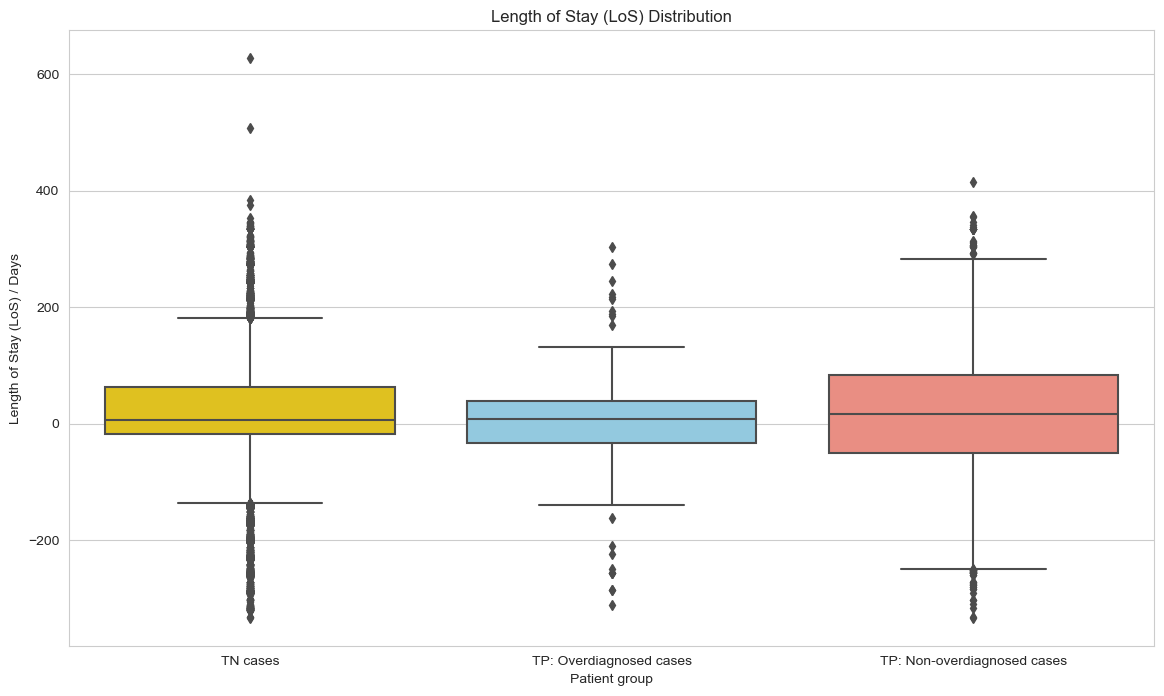

In [127]:
# Filter admission, discharge, and expire flag events
admissions_TP_only = Event_log_TP_only_with_OD_and_Non_od_label[Event_log_TP_only_with_OD_and_Non_od_label['event'] == 'admission'] # 1053
discharges_TP_only = Event_log_TP_only_with_OD_and_Non_od_label[Event_log_TP_only_with_OD_and_Non_od_label['event'] == 'discharge'] # 817
expire_flags_TP_only= Event_log_TP_only_with_OD_and_Non_od_label[Event_log_TP_only_with_OD_and_Non_od_label['event'] == 'hospital_expire_flag_1'] # 236

# Merge admission and discharge/expire times
los_df_TP_only = pd.merge(admissions_TP_only[['hadm_id', 'event_time']], discharges_TP_only[['hadm_id', 'event_time']], on='hadm_id', how='left', suffixes=('_admission', '_discharge')) # columns 'event_time' and 'event_time' will rename with 'event_time_admission' and 'event_time_discharge'.

los_df_TP_only = pd.merge(los_df_TP_only, expire_flags_TP_only[['hadm_id', 'event_time']], on='hadm_id', how='left')
los_df_TP_only.rename(columns={'event_time': 'event_time_expire'}, inplace=True)

# Determine the actual discharge time
# This column will have the event_time from hospital_expire_flag_1 if it exists for the hadm_id, otherwise, it will have the event_time from discharge.

los_df_TP_only['event_time_actual_discharge'] = los_df_TP_only['event_time_expire'].combine_first(los_df_TP_only['event_time_discharge'])

# Calculate Length of Stay (LoS) in days
los_df_TP_only['LoS'] = (los_df_TP_only['event_time_actual_discharge'] - los_df_TP_only['event_time_admission']).dt.total_seconds() / 86400  # Convert seconds to days

# Create the final data frame
LoS_TP_only = los_df_TP_only[['hadm_id', 'LoS']]

#--------------------------------------------------

# Merge the data frames
merged_cluster_with_LoS_with_OD_and_Non_od_label = pd.merge((Event_log_TP_only_with_OD_and_Non_od_label[['hadm_id', 'cluster_index', 'patient_count','TP_percentage', 'OD_or_Non_od']].drop_duplicates()), LoS_TP_only, on='hadm_id')

# check output stats
print(merged_cluster_with_LoS_with_OD_and_Non_od_label.groupby('OD_or_Non_od')['LoS'].describe())

# Create the box plot
plt.figure(figsize=(14, 8))
custom_palette = {'TN': 'gold', 'OD': 'skyblue', 'Non_OD': 'salmon'}
ax = sns.boxplot(x='OD_or_Non_od', y='LoS', data=merged_cluster_with_LoS_with_OD_and_Non_od_label, order=['TN', 'OD', 'Non_OD'], palette=custom_palette)

# Set the plot labels and title
plt.xlabel('Patient group')
plt.ylabel('Length of Stay (LoS) / Days')
plt.title('Length of Stay (LoS) Distribution')
#plt.legend(title='TP Category')

# Set custom x-tick labels
ax.set_xticklabels(['TN cases', 'TP: Overdiagnosed cases', 'TP: Non-overdiagnosed cases'])

# Show the plot
plt.show()

# 3.1.2 Thrombotic events

[41.92948263642807, 48.68421052631579, 80.75742067553736]


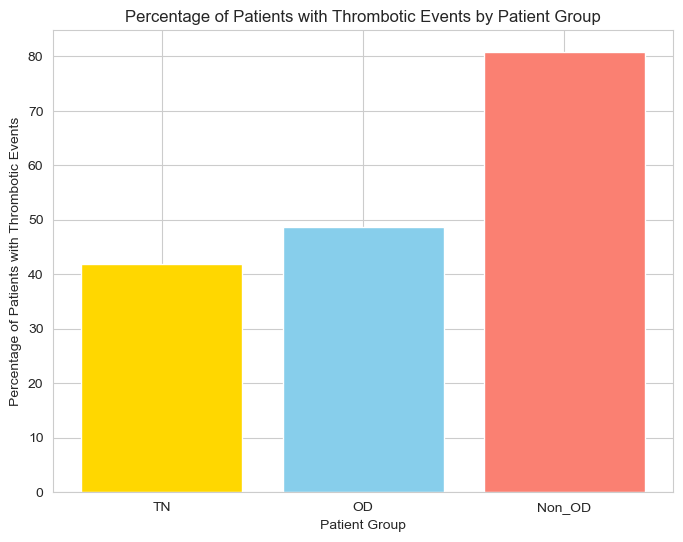

In [130]:
# How many OD patients had thrombotic events?

Thrombotic_events_in_OD_patients = OD_patients_evets_list[OD_patients_evets_list['event']=='First_Thrombosis_or_Embolism']['hadm_id'].nunique() # 66

# How many Non-OD patients had thrombotic events?

Thrombotic_events_in_Non_od_patients = Non_OD_patients_evets_list[Non_OD_patients_evets_list['event']=='First_Thrombosis_or_Embolism']['hadm_id'].nunique() # 760

# How many TN patients had thrombotic events?

Thrombotic_events_in_TN_patients = TN_patients_evets_list[TN_patients_evets_list['event']=='First_Thrombosis_or_Embolism']['hadm_id'].nunique() # 760

# percentages

# OD_patients_percentage_with_thrombotic_events is set to zero if OD_patients_count is zero, preventing a ZeroDivisionError. Similarly, it also handles the case where Non_OD_patients_count is zero.

OD_patients_percentage_with_thrombotic_events = (Thrombotic_events_in_OD_patients / OD_patients_count * 100) if OD_patients_count != 0 else 0

Non_OD_patients_percentage_with_thrombotic_events = (Thrombotic_events_in_Non_od_patients / Non_OD_patients_count *100) if Non_OD_patients_count != 0 else 0

TN_patients_percentage_with_thrombotic_events = (Thrombotic_events_in_TN_patients / TN_patients_count *100) if TN_patients_count != 0 else 0

x = ['TN', 'OD' , 'Non_OD']
y = [TN_patients_percentage_with_thrombotic_events, OD_patients_percentage_with_thrombotic_events , Non_OD_patients_percentage_with_thrombotic_events]

print(y) #check output

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(x, y, color=['gold', 'skyblue', 'salmon'])#, width = 0.4)
# plt.bar(x, y, color=['yellow','blue', 'red'])#, width = 0.4)

# Add titles and labels
plt.title('Percentage of Patients with Thrombotic Events by Patient Group')
plt.xlabel('Patient Group')
plt.ylabel('Percentage of Patients with Thrombotic Events')

# Display the plot
plt.show()


# 3.1.3 Mortality

[7.48582565556343, 5.263157894736842, 23.74616171954964]


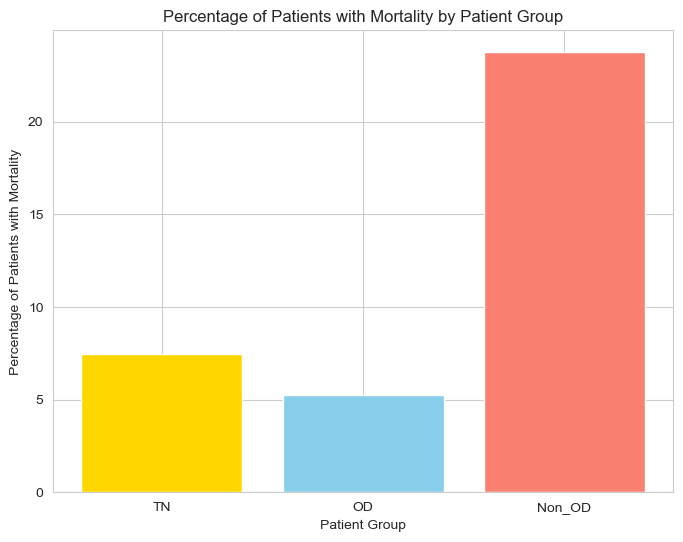

In [131]:
# How many OD patients had thrombotic events?

Mortality_in_OD_patients = OD_patients_evets_list[OD_patients_evets_list['event']=='hospital_expire_flag_1']['hadm_id'].nunique() # 209

# How many Non-OD patients had thrombotic events?

Mortality_in_Non_od_patients = Non_OD_patients_evets_list[Non_OD_patients_evets_list['event']=='hospital_expire_flag_1']['hadm_id'].nunique() # 27

# How many TN patients had thrombotic events?

Mortality_in_TN_patients = TN_patients_evets_list[TN_patients_evets_list['event']=='hospital_expire_flag_1']['hadm_id'].nunique() # 27

# percentages

# OD_patients_percentage_with_thrombotic_events is set to zero if OD_patients_count is zero, preventing a ZeroDivisionError. Similarly, it also handles the case where Non_OD_patients_count is zero.

OD_patients_percentage_with_Mortality = (Mortality_in_OD_patients / OD_patients_count * 100) if OD_patients_count != 0 else 0

Non_OD_patients_percentage_with_Mortality = (Mortality_in_Non_od_patients / Non_OD_patients_count *100) if Non_OD_patients_count != 0 else 0

TN_patients_percentage_with_Mortality = (Mortality_in_TN_patients / TN_patients_count *100) if TN_patients_count != 0 else 0

x = ['TN', 'OD' , 'Non_OD']
y = [TN_patients_percentage_with_Mortality, OD_patients_percentage_with_Mortality , Non_OD_patients_percentage_with_Mortality]

print(y) # check output

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(x, y, color=['gold', 'skyblue', 'salmon'])#, width = 0.4)
# plt.bar(x, y, color=['yellow','blue', 'red'])#, width = 0.4)

# Add titles and labels
plt.title('Percentage of Patients with Mortality by Patient Group')
plt.xlabel('Patient Group')
plt.ylabel('Percentage of Patients with Mortality')

# Display the plot
plt.show()

# 3.1.4 All plots on a one figure

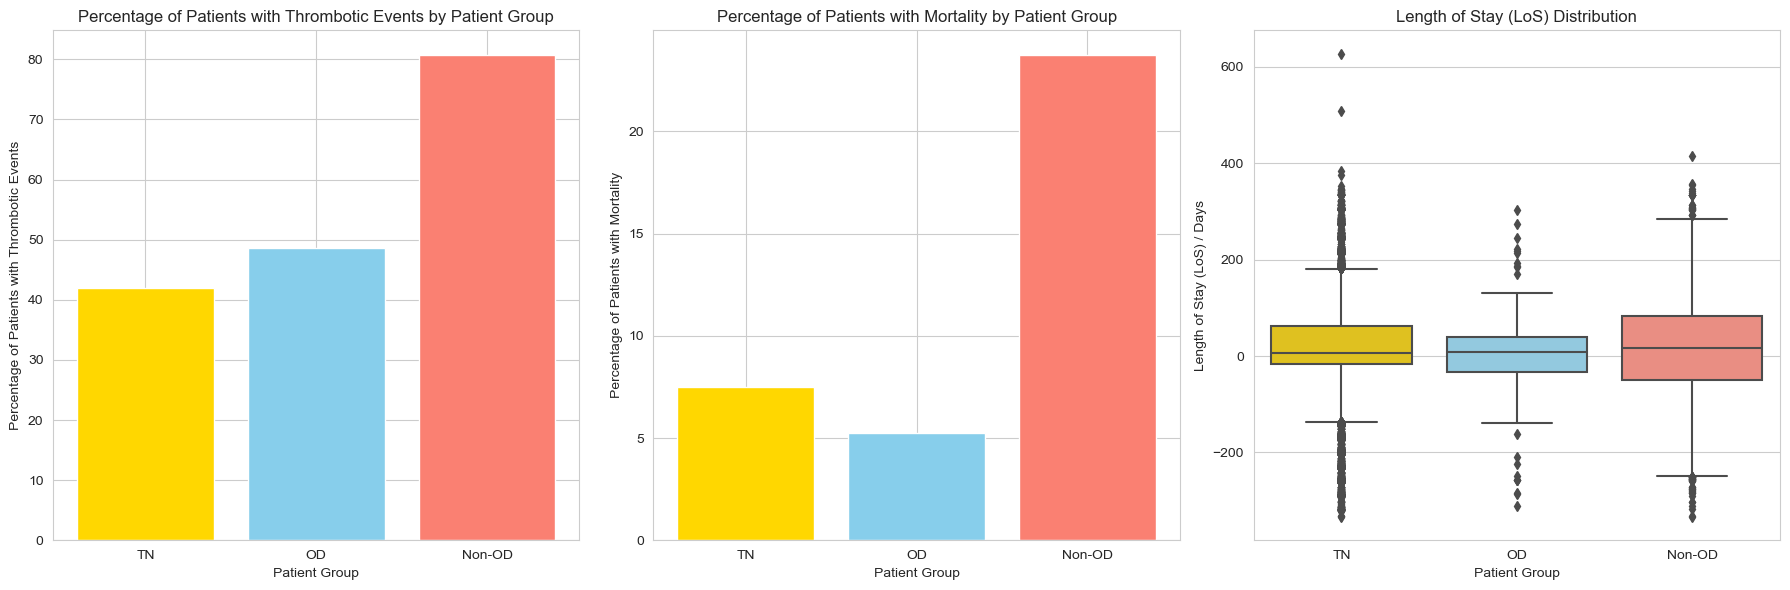

In [132]:
# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First figure: Percentage of Patients with Thrombotic Events
x = ['TN', 'OD', 'Non-OD']
y = [
    TN_patients_percentage_with_thrombotic_events,
    OD_patients_percentage_with_thrombotic_events,
    Non_OD_patients_percentage_with_thrombotic_events
]

axs[0].bar(x, y, color=['gold', 'skyblue', 'salmon'])
axs[0].set_title('Percentage of Patients with Thrombotic Events by Patient Group')
axs[0].set_xlabel('Patient Group')
axs[0].set_ylabel('Percentage of Patients with Thrombotic Events')

# Second figure: Percentage of Patients with Mortality
x = ['TN', 'OD', 'Non-OD']
y = [
    TN_patients_percentage_with_Mortality,
    OD_patients_percentage_with_Mortality,
    Non_OD_patients_percentage_with_Mortality
]

axs[1].bar(x, y, color=['gold', 'skyblue', 'salmon'])
axs[1].set_title('Percentage of Patients with Mortality by Patient Group')
axs[1].set_xlabel('Patient Group')
axs[1].set_ylabel('Percentage of Patients with Mortality')

# Third figure: Length of Stay (LoS) Distribution
custom_palette = {'TN': 'gold', 'OD': 'skyblue', 'Non_OD': 'salmon'}
sns.boxplot(x='OD_or_Non_od', y='LoS', data=merged_cluster_with_LoS_with_OD_and_Non_od_label, order=['TN', 'OD', 'Non_OD'], palette=custom_palette, ax=axs[2])
axs[2].set_xlabel('Patient Group')
axs[2].set_ylabel('Length of Stay (LoS) / Days')
axs[2].set_title('Length of Stay (LoS) Distribution')

# Set custom x-tick labels for the third subplot
axs[2].set_xticklabels(['TN', 'OD', 'Non-OD'])

# Adjust layout
plt.tight_layout()
plt.show()


# 3.2 Clinical outcomes in cluster-level

# 3.2.1 LoS

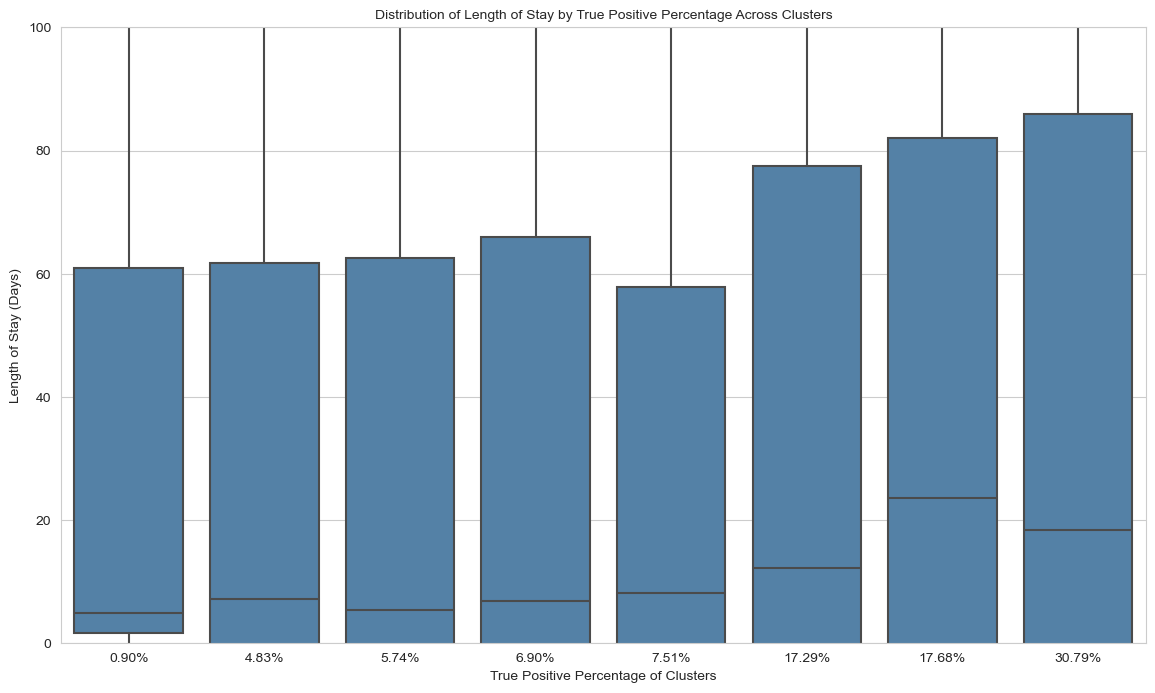

In [133]:
# To make sure TP percentage is in ascending order

merged_cluster_with_LoS_with_OD_and_Non_od_label = merged_cluster_with_LoS_with_OD_and_Non_od_label.sort_values(by='TP_percentage')

After_removing_outliers_clusters = merged_cluster_with_LoS_with_OD_and_Non_od_label[merged_cluster_with_LoS_with_OD_and_Non_od_label['patient_count']>5]
# Create the box plot
plt.figure(figsize=(14, 8))

ax2 = sns.boxplot(x='cluster_index', y='LoS', data=After_removing_outliers_clusters, color='#4682B4')
#sns.boxplot(x='TP% of each Cluster', y='Length of Stay (Days)', title = 'hjhk', data=After_removing_outliers_clusters)

# Set the plot labels and title
ax2.set_xlabel('True Positive Percentage of Clusters',fontsize=10)
ax2.set_ylabel('Length of Stay (Days)',fontsize=10)
ax2.set_title('Distribution of Length of Stay by True Positive Percentage Across Clusters',fontsize=10)


# Customizing the x-tick labels
cluster_indexes = After_removing_outliers_clusters['cluster_index'].unique()
tp_percentages = After_removing_outliers_clusters.groupby('cluster_index')['TP_percentage'].first().loc[cluster_indexes]

# Creating custom x-tick label
#xtick_labels = [f'{index} ({tp:.2f}%)' for index, tp in zip(cluster_indexes, tp_percentages)]

xtick_labels = [f'{tp:.2f}%' for index, tp in zip(cluster_indexes, tp_percentages)]

# Set the custom x-tick labels
plt.xticks(ticks=np.arange(len(cluster_indexes)), labels=xtick_labels)

# Limit the y-axis from 0 to 100
plt.ylim(0, 100)

# Show the plot
plt.show()

# 3.2.2 Thrombotic events

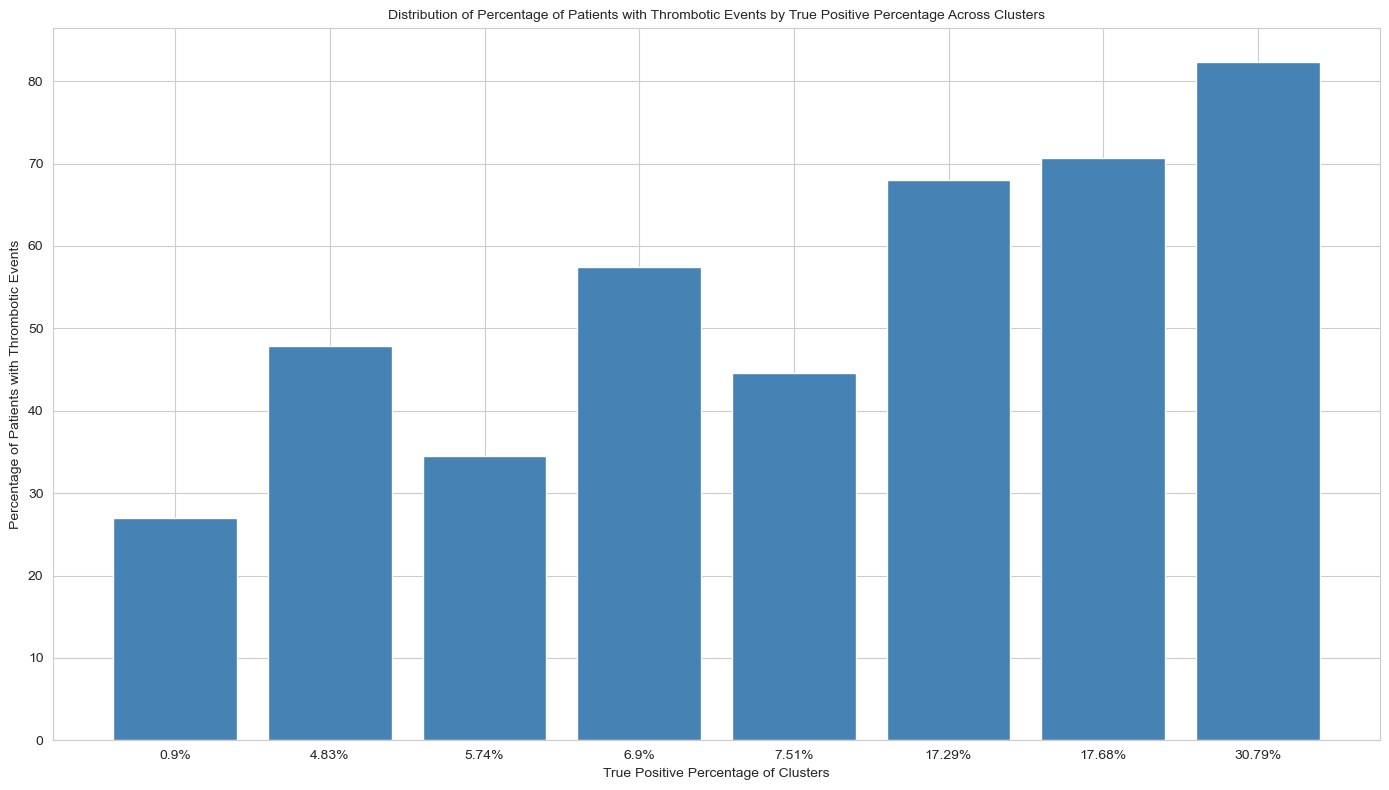

In [134]:
# Ensure the DataFrame is sorted by 'TP_percentage'
sorted_df_Thrombotic_events_count = Thrombotic_events_count_of_each_cluster_class_wise.sort_values(by='TP_percentage')

# Create the bar plot
plt.figure(figsize=(14, 8))
plt.bar(sorted_df_Thrombotic_events_count['TP_percentage'].astype(str), sorted_df_Thrombotic_events_count['Thromb_per'], color='#4682B4')

# Add titles and labels
plt.xlabel('True Positive Percentage of Clusters',fontsize=10)
plt.ylabel('Percentage of Patients with Thrombotic Events',fontsize=10)
plt.title('Distribution of Percentage of Patients with Thrombotic Events by True Positive Percentage Across Clusters',fontsize=10)

# Round x-ticks to two decimal places

#np.arange(len(sorted_df['TP_percentage'])): Creates an array of tick positions based on the number of TP percentage values in the DataFrame. For example, if there are 5 TP percentages, it generates an array [0, 1, 2, 3, 4]. This defines where the ticks will be placed on the x-axis.
#np.round(sorted_df['TP_percentage'].values, 2): Rounds the TP percentage values to two decimal places. This ensures that the tick labels on the x-axis are formatted with two decimal places.
#plt.xticks(ticks=..., labels=...): Sets the x-axis tick positions and labels. The ticks argument specifies where the ticks should appear on the x-axis, and the labels argument specifies what text should be displayed at each tick position.

plt.xticks(
    ticks=np.arange(len(sorted_df_Thrombotic_events_count['TP_percentage'])),
    labels=[f"{round(tp, 2)}%" for tp in sorted_df_Thrombotic_events_count['TP_percentage'].values]
)

# Display the plot
plt.tight_layout()
plt.show()
#Chapter6_Fig9_1.png

# 3.2.3 Mortality

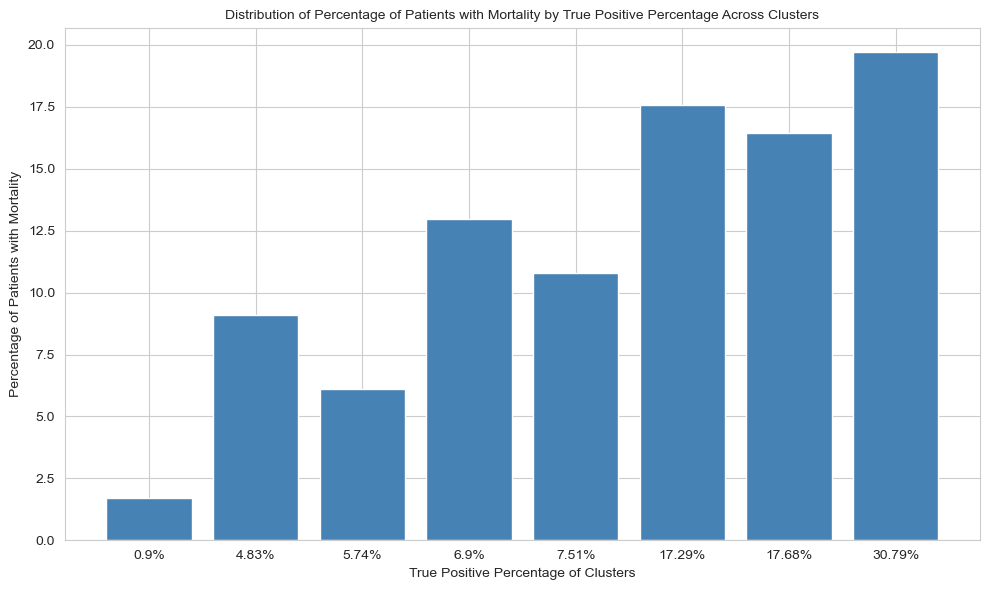

In [135]:
# Ensure the DataFrame is sorted by 'TP_percentage'
sorted_df_Mortality_count = Mortality_each_cluster_class_wise.sort_values(by='TP_percentage')

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_df_Mortality_count['TP_percentage'].astype(str), sorted_df_Mortality_count['Mortality_per'], color='#4682B4')

# Add titles and labels

plt.xlabel('True Positive Percentage of Clusters',fontsize=10)
plt.ylabel('Percentage of Patients with Mortality',fontsize=10)
plt.title('Distribution of Percentage of Patients with Mortality by True Positive Percentage Across Clusters',fontsize=10)

# Round x-ticks to two decimal places

#np.arange(len(sorted_df['TP_percentage'])): Creates an array of tick positions based on the number of TP percentage values in the DataFrame. For example, if there are 5 TP percentages, it generates an array [0, 1, 2, 3, 4]. This defines where the ticks will be placed on the x-axis.
#np.round(sorted_df['TP_percentage'].values, 2): Rounds the TP percentage values to two decimal places. This ensures that the tick labels on the x-axis are formatted with two decimal places.
#plt.xticks(ticks=..., labels=...): Sets the x-axis tick positions and labels. The ticks argument specifies where the ticks should appear on the x-axis, and the labels argument specifies what text should be displayed at each tick position.

plt.xticks(
    ticks=np.arange(len(sorted_df_Thrombotic_events_count['TP_percentage'])),
    labels=[f"{round(tp, 2)}%" for tp in sorted_df_Thrombotic_events_count['TP_percentage'].values]
)
# Display the plot
plt.tight_layout()
plt.show()


# 3.3 Check whether there is a 'Trend' in the distribution of Thrombotic events percentage and the mortality percentage against TP percentages inside each cluster.
### done only for thrombotic events and Mortality (Didn't apply for LoS as it is continuous)

## 3.3.1 - Thrombotic events percentage

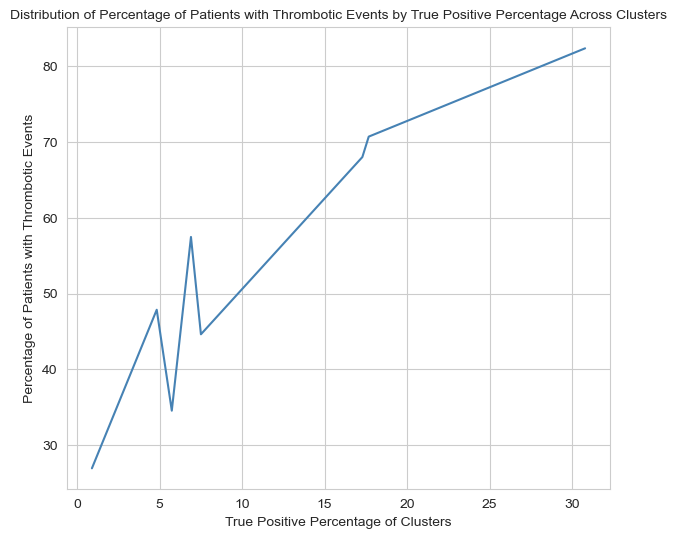

In [136]:
# Sort the unique values of 'TP_percentage'
#order = sorted(Thromp_per_with_TP_per_in_clusters['TP_percentage'].unique())

# Create the box plot with the sorted x-axis
plt.figure(figsize=(7, 6))
plt.plot(Thromp_per_with_TP_per_in_clusters['TP_percentage'], Thromp_per_with_TP_per_in_clusters['Thromb_per'], color='#4682B4')

plt.xlabel('True Positive Percentage of Clusters',fontsize=10)
plt.ylabel('Percentage of Patients with Thrombotic Events',fontsize=10)
plt.title('Distribution of Percentage of Patients with Thrombotic Events by True Positive Percentage Across Clusters',fontsize=10)

plt.grid(True)
plt.show()


plt.show()

In [137]:
# Define the independent variable (TP_percentage) and dependent variable (Thromb_per)
X = Thromp_per_with_TP_per_in_clusters['TP_percentage']
y = Thromp_per_with_TP_per_in_clusters['Thromb_per']

# Add a constant to the independent variable (for intercept in the regression model)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())

p_value_tp_percentage = model.pvalues['TP_percentage']
print(f'P-value for TP_percentage: {p_value_tp_percentage}')

# P-Value  (Prob (F-statistic):) returned 0.001 - This reflects that the trend is statistically significant

                            OLS Regression Results                            
Dep. Variable:             Thromb_per   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     31.22
Date:                Fri, 18 Oct 2024   Prob (F-statistic):            0.00140
Time:                        14:18:19   Log-Likelihood:                -27.078
No. Observations:                   8   AIC:                             58.16
Df Residuals:                       6   BIC:                             58.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            33.6922      4.667      7.219

/Users/psenevirathn/.conda/envs/myproject2/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 3.3.2 - Mortality percentage

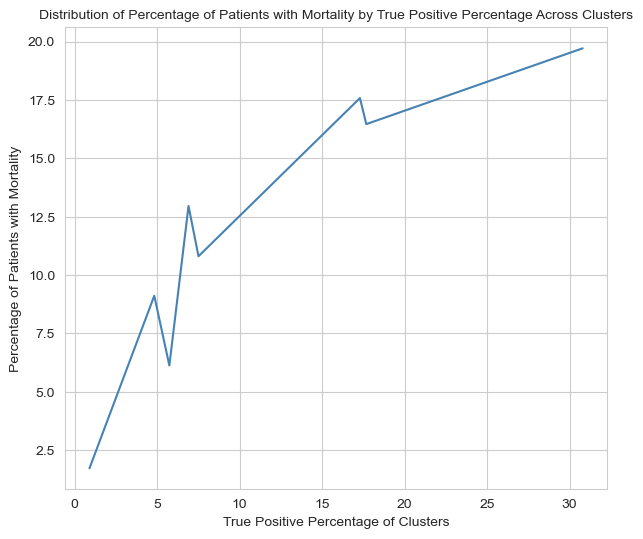

In [138]:
# Sort the unique values of 'TP_percentage'
#order = sorted(Thromp_per_with_TP_per_in_clusters['TP_percentage'].unique())
plt.figure(figsize=(7, 6))
# Create the box plot with the sorted x-axis
plt.plot(Mortality_per_with_TP_per_in_clusters['TP_percentage'], Mortality_per_with_TP_per_in_clusters['Mortality_per'], color='#4682B4')

plt.xlabel('True Positive Percentage of Clusters',fontsize=10)
plt.ylabel('Percentage of Patients with Mortality',fontsize=10)
plt.title('Distribution of Percentage of Patients with Mortality by True Positive Percentage Across Clusters',fontsize=10)

plt.grid(True)
plt.show()


plt.show()

In [139]:
# Define the independent variable (TP_percentage) and dependent variable (Mortality_per)
X = Mortality_per_with_TP_per_in_clusters['TP_percentage']
y = Mortality_per_with_TP_per_in_clusters['Mortality_per']

# Add a constant to the independent variable (for intercept in the regression model)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())

p_value_tp_percentage = model.pvalues['TP_percentage']
print(f'P-value for TP_percentage: {p_value_tp_percentage}')

# P-Value returned 0.003 - This reflects that the trend is statistically significant

                            OLS Regression Results                            
Dep. Variable:          Mortality_per   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     22.01
Date:                Fri, 18 Oct 2024   Prob (F-statistic):            0.00336
Time:                        14:18:20   Log-Likelihood:                -19.127
No. Observations:                   8   AIC:                             42.25
Df Residuals:                       6   BIC:                             42.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.4805      1.728      3.172

/Users/psenevirathn/.conda/envs/myproject2/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# 3.4 Check P-values of clinical outcomes for Groups OD/Non-OD/TN
### done only for thrombotic events and Mortality (Didn't apply for LoS as it is continuous)

In [140]:
TN_patients_no_thrombotic_events = TN_patients_count - Thrombotic_events_in_TN_patients
OD_patients_no_thrombotic_events = OD_patients_count - Thrombotic_events_in_OD_patients
Non_OD_patients_no_thrombotic_events = Non_OD_patients_count - Thrombotic_events_in_Non_od_patients

contingency_non_od_vs_od = np.array([
    [Thrombotic_events_in_Non_od_patients, Non_OD_patients_no_thrombotic_events],
    [Thrombotic_events_in_OD_patients, OD_patients_no_thrombotic_events]
])

contingency_od_vs_tn = np.array([
    [Thrombotic_events_in_OD_patients, OD_patients_no_thrombotic_events],
    [Thrombotic_events_in_TN_patients, TN_patients_no_thrombotic_events]
])

# Step 3: Perform Chi-squared tests
chi2_non_od_od, p_non_od_od, _, _ = chi2_contingency(contingency_non_od_vs_od)
chi2_od_tn, p_od_tn, _, _ = chi2_contingency(contingency_od_vs_tn)

# Step 4: Print results
print(f"Non-OD vs OD: p-value_Thrombotic_events = {p_non_od_od}")
print(f"OD vs TN: p-value_Thrombotic_events = {p_od_tn}")

Non-OD vs OD: p-value_Thrombotic_events = 1.5066708052012903e-10
OD vs TN: p-value_Thrombotic_events = 0.28345270161476754


In [141]:
TN_patients_no_Mortality = TN_patients_count - Mortality_in_TN_patients
OD_patients_no_Mortality = OD_patients_count - Mortality_in_OD_patients
Non_OD_patients_no_Mortality = Non_OD_patients_count - Mortality_in_Non_od_patients

contingency_non_od_vs_od_Mortality = np.array([
    [Mortality_in_Non_od_patients, Non_OD_patients_no_Mortality],
    [Mortality_in_OD_patients, OD_patients_no_Mortality]
])

contingency_od_vs_tn_Mortality = np.array([
    [Mortality_in_OD_patients, OD_patients_no_Mortality],
    [Mortality_in_TN_patients, TN_patients_no_Mortality]
])

# Step 3: Perform Chi-squared tests
chi2_non_od_od_Mortality, p_non_od_od_Mortality, _, _ = chi2_contingency(contingency_non_od_vs_od_Mortality)
chi2_od_tn_Mortality, p_od_tn_Mortality, _, _ = chi2_contingency(contingency_od_vs_tn_Mortality)

# Step 4: Print results

print(f"Non-OD vs OD_Mortality: p-value_Mortality = {p_non_od_od_Mortality}")
print(f"OD vs TN_Mortality: p-value_Mortality = {p_od_tn_Mortality}")

Non-OD vs OD_Mortality: p-value_Mortality = 0.00034466087837348636
OD vs TN_Mortality: p-value_Mortality = 0.6061091409980017


# 4. Re-train the label

In [142]:
train_labels = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Python/input_csv_files/label_train_actual_and_predicted.csv')
test_labels = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Python/input_csv_files/label_test_actual_and_predicted.csv')

train_labels['data_set']='train'
test_labels['data_set']='test'

both_train_test_labels = pd.concat([train_labels, test_labels], axis=0).drop('Unnamed: 0', axis=1) #both_train_test_labels.shape # 13415*4

In [143]:
# add a column 'OD', so that only the OD patients have a value ('OD') for this column

OD_patients_hadm_list['OD'] = 'OD'

# Rename the columns for better readability
both_train_test_labels.rename(columns={'HIT_label_actual': 'previous_HIT_label'}, inplace=True)

join_original_train_test_labels_with_OD_hadm_id_list = pd.merge(both_train_test_labels, OD_patients_hadm_list[['hadm_id', 'OD']], on='hadm_id', how='left')

# Add the new column 'updated_label' - if patients is 'OD', then set the label to 'HIT negative' - ('0')
join_original_train_test_labels_with_OD_hadm_id_list['updated_HIT_label'] = np.where(join_original_train_test_labels_with_OD_hadm_id_list['OD'].notnull(), 0, join_original_train_test_labels_with_OD_hadm_id_list['previous_HIT_label'])

join_original_train_test_labels_with_OD_hadm_id_list

# previous label - join_original_train_test_labels_with_OD_hadm_id_list['class'] - TP-1053 / TN-11288 / FP-138 / FN-936
# new label - join_original_train_test_labels_with_OD_hadm_id_list['updated_label'] - TP-950 / TN-11398 / FP-104 / FN-963
# 101 OD patients were moved from 'TP' to 'TN'.

/var/folders/hd/ds7hts1d50j2wcpcm9y14v440000gn/T/ipykernel_95472/2856432325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OD_patients_hadm_list['OD'] = 'OD'


,hadm_id,previous_HIT_label,HIT_label_predicted,data_set,OD,updated_HIT_label
0,25057826,0,0,train,NaN,0
1,23053461,0,0,train,NaN,0
2,26688266,0,0,train,NaN,0
3,25289494,0,0,train,NaN,0
4,27228569,0,0,train,NaN,0
...,...,...,...,...,...,...
13410,23474370,0,0,test,NaN,0
13411,27477783,0,0,test,NaN,0
13412,29487881,0,0,test,NaN,0
13413,23173302,0,0,test,NaN,0


In [144]:
join_original_train_test_labels_with_OD_hadm_id_list.columns

Index(['hadm_id', 'previous_HIT_label', 'HIT_label_predicted', 'data_set',
       'OD', 'updated_HIT_label'],
      dtype='object')

In [146]:
# save updated HIT labels

#file_path = '/Users/psenevirathn/Desktop/PhD/Coding/Python/input_csv_files/After_clustering/updated_labels.csv'
file_path = '/Users/psenevirathn/Desktop/PhD/Coding/Python/input_csv_files/After_clustering/updated_labels_new_TP_to_TN_ratio_as_baseline.csv'

#join_original_train_test_labels_with_OD_hadm_id_list.to_csv(file_path, index=False)

# 4.1 Analyzing OD patients after re-training the classifier with update label


In [148]:
train_labels_after_retrain = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Python/output_csv_files/label_train_actual_and_predicted_with_updated_ground_truth_New_TP_to_TN_as_baseline.csv')
test_labels_after_retrain = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Python/output_csv_files/label_test_actual_and_predicted_with_updated_ground_truth_New_TP_to_TN_as_baseline.csv')

train_labels_after_retrain['data_set']='train'
test_labels_after_retrain['data_set']='test'

both_train_test_labels_after_retrain = pd.concat([train_labels_after_retrain, test_labels_after_retrain], axis=0).drop('Unnamed: 0', axis=1) #both_train_test_labels.shape # 13415*4

In [149]:
both_train_test_labels_after_retrain.rename(columns={
    'HIT_label_actual': 'HIT_label_after_update',
    'HIT_label_predicted': 'HIT_label_predicted_after_update'
}, inplace=True)

In [150]:
join_original_train_test_labels_with_OD_hadm_id_list.rename(columns={
    'previous_HIT_label': 'HIT_label_before_update',
    'HIT_label_predicted': 'HIT_label_predicted_before_update'
}, inplace=True)


In [151]:
all_labels_before_and_after_retrain = pd.merge((join_original_train_test_labels_with_OD_hadm_id_list[['hadm_id', 'OD', 'data_set', 'HIT_label_before_update', 'HIT_label_predicted_before_update']]), (both_train_test_labels_after_retrain[['hadm_id', 'HIT_label_after_update', 'HIT_label_predicted_after_update']]), how='left', on='hadm_id')

all_labels_before_and_after_retrain

,hadm_id,OD,data_set,HIT_label_before_update,HIT_label_predicted_before_update,HIT_label_after_update,HIT_label_predicted_after_update
0,25057826,NaN,train,0,0,0,0
1,23053461,NaN,train,0,0,0,0
2,26688266,NaN,train,0,0,0,0
3,25289494,NaN,train,0,0,0,0
4,27228569,NaN,train,0,0,0,0
...,...,...,...,...,...,...,...
13410,23474370,NaN,test,0,0,0,0
13411,27477783,NaN,test,0,0,0,0
13412,29487881,NaN,test,0,0,0,0
13413,23173302,NaN,test,0,0,0,0


In [152]:
# Function to determine class_before_update
def determine_class_before(row):
    if row['HIT_label_before_update'] == 1 and row['HIT_label_predicted_before_update'] == 1:
        return 'TP'
    elif row['HIT_label_before_update'] == 0 and row['HIT_label_predicted_before_update'] == 0:
        return 'TN'
    elif row['HIT_label_before_update'] == 0 and row['HIT_label_predicted_before_update'] == 1:
        return 'FP'
    elif row['HIT_label_before_update'] == 1 and row['HIT_label_predicted_before_update'] == 0:
        return 'FN'

# Function to determine class_after_update
def determine_class_after(row):
    if row['HIT_label_after_update'] == 1 and row['HIT_label_predicted_after_update'] == 1:
        return 'TP'
    elif row['HIT_label_after_update'] == 0 and row['HIT_label_predicted_after_update'] == 0:
        return 'TN'
    elif row['HIT_label_after_update'] == 0 and row['HIT_label_predicted_after_update'] == 1:
        return 'FP'
    elif row['HIT_label_after_update'] == 1 and row['HIT_label_predicted_after_update'] == 0:
        return 'FN'

In [153]:
# Apply the functions to create the new columns
all_labels_before_and_after_retrain['class_before_update'] = all_labels_before_and_after_retrain.apply(determine_class_before, axis=1)
all_labels_before_and_after_retrain['class_after_update'] = all_labels_before_and_after_retrain.apply(determine_class_after, axis=1)

all_labels_before_and_after_retrain.reset_index(drop=True)

,hadm_id,OD,data_set,HIT_label_before_update,HIT_label_predicted_before_update,HIT_label_after_update,HIT_label_predicted_after_update,class_before_update,class_after_update
0,25057826,NaN,train,0,0,0,0,TN,TN
1,23053461,NaN,train,0,0,0,0,TN,TN
2,26688266,NaN,train,0,0,0,0,TN,TN
3,25289494,NaN,train,0,0,0,0,TN,TN
4,27228569,NaN,train,0,0,0,0,TN,TN
...,...,...,...,...,...,...,...,...,...
13410,23474370,NaN,test,0,0,0,0,TN,TN
13411,27477783,NaN,test,0,0,0,0,TN,TN
13412,29487881,NaN,test,0,0,0,0,TN,TN
13413,23173302,NaN,test,0,0,0,0,TN,TN


In [155]:
all_labels_before_and_after_retrain['class_before_update'].value_counts()

TN    11288
TP     1053
FN      936
FP      138
Name: class_before_update, dtype: int64

In [156]:
all_labels_before_and_after_retrain['class_after_update'].value_counts()

TN    11398
FN      963
TP      950
FP      104
Name: class_after_update, dtype: int64

In [157]:
# Analyze only OD patients (previous 135 OD patients - TP always)

all_labels_before_and_after_retrain[(all_labels_before_and_after_retrain['OD']=='OD')]['class_after_update'].value_counts()

#all_labels_before_and_after_retrain[(all_labels_before_and_after_retrain['OD']=='OD') & (all_labels_before_and_after_retrain['data_set']=='test')]['class_after_update'].value_counts()

TN    68
FP     8
Name: class_after_update, dtype: int64

# 4.2 Calculate likelihood ratios

## 4.2.1 - Blind test with original label

In [46]:
# with original label
# [[2207   78]
# [ 286  112]]

TP = 112
TN = 2207
FP = 78
FN = 286

Balanced_accuracy = 0.624
Senitivity_OR_Recall = 0.281

Specificity = (Balanced_accuracy/0.5) - Senitivity_OR_Recall

LR_pos = Senitivity_OR_Recall/(1-Specificity)

LR_neg = (1 - Senitivity_OR_Recall)/Specificity

print(Specificity)
print(LR_pos)
print(LR_neg)

ppv = TP/(TP+FP)
npv = TN/(TN+FN)

print(ppv)
print(npv)

0.967
8.515151515151508
0.7435367114788004
0.5894736842105263
0.8852787805856398


## 4.2.2 - 10-CV test with original label

In [50]:
### cannot generate a confusion matrix directly-coz o.w. need 10 matrices
# But we can do, is y_test is a at test_set in one of the folds in 10-folds. In 10-fold cross-validation using cross_val_predict, the function does indeed return a single array of predictions for the entire dataset, but it does this by aggregating predictions made during each of the folds

#[8823  318 
# 1135  456]

TP = 456
TN = 8823
FP = 318
FN = 1135

Balanced_accuracy = 0.626
Senitivity_OR_Recall = 0.287

Specificity = (Balanced_accuracy/0.5) - Senitivity_OR_Recall

LR_pos = Senitivity_OR_Recall/(1-Specificity)

LR_neg = (1 - Senitivity_OR_Recall)/Specificity

print(Specificity)
print(LR_pos)
print(LR_neg)

0.9650000000000001
8.200000000000019
0.738860103626943


In [51]:
# can also calculate as below. However, we already calculated in /Users/psenevirathn/PycharmProjects/myproject2/current_codes/4_Jan_3_Train_model_after_feature_selection.py

ppv = TP/(TP+FP)
npv = TN/(TN+FN)

print(ppv)
print(npv)

0.5891472868217055
0.8860212894155453


## 4.2.3 - Blind test with updated label

In [47]:
# with updated label
##[[2226   67]
##[ 299   91]]

TP = 91
TN = 2226
FP = 67
FN = 299

Balanced_accuracy = 0.602
Senitivity_OR_Recall = 0.233

Specificity = (Balanced_accuracy/0.5) - Senitivity_OR_Recall

LR_pos = Senitivity_OR_Recall/(1-Specificity)

LR_neg = (1 - Senitivity_OR_Recall)/Specificity

print(Specificity)
print(LR_pos)
print(LR_neg)

ppv = TP/(TP+FP)
npv = TN/(TN+FN)

print(ppv)
print(npv)

0.971
8.034482758620683
0.7899073120494337
0.5759493670886076
0.8815841584158416


## 4.2.4 - 10-CV test with updated label

In [44]:
### cannot generate a confusion matrix directly-coz o.w. need 10 matrices
# But we can do, is y_test is a at test_set in one of the folds in 10-folds. In 10-fold cross-validation using cross_val_predict, the function does indeed return a single array of predictions for the entire dataset, but it does this by aggregating predictions made during each of the folds

#[8929  280 
 #1146  377]  

TP = 377
TN = 8929
FP = 280
FN = 1146

Balanced_accuracy = 0.609
Senitivity_OR_Recall = 0.247

Specificity = (Balanced_accuracy/0.5) - Senitivity_OR_Recall

LR_pos = Senitivity_OR_Recall/(1-Specificity)

LR_neg = (1 - Senitivity_OR_Recall)/Specificity

print(Specificity)
print(LR_pos)
print(LR_neg)

0.971
8.517241379310336
0.7754891864057673


In [45]:
# can also calculate as below. However, we already calculated in /Users/psenevirathn/PycharmProjects/myproject2/current_codes/10_retrain_classifer_with_updated_labels.py

ppv = TP/(TP+FP)
npv = TN/(TN+FN)

print(ppv)
print(npv)

0.573820395738204
0.8862531017369727


## 4.2.5 - Blind test with original label (HIT positive:HIT negative = 1:2)

In [52]:
# HIT classifier - balanced data (blind test)

### [[1971    314]
###   186    212]]

TP = 212
TN = 1971
FP = 314
FN = 186

Balanced_accuracy = 0.698
Senitivity_OR_Recall = 0.533

Specificity = (Balanced_accuracy / 0.5) - Senitivity_OR_Recall

LR_pos = Senitivity_OR_Recall / (1 - Specificity)

LR_neg = (1 - Senitivity_OR_Recall) / Specificity

print(Specificity)
print(LR_pos)
print(LR_neg)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(ppv)
print(npv)

0.8629999999999999
3.8905109489051064
0.5411355735805331
0.40304182509505704
0.913769123783032


## 4.2.6 - 10-CV test with original label (HIT positive:HIT negative = 1:2)

In [53]:
# HIT classifier - balanced data - 10-CV test

### cannot generate a confusion matrix directly-coz o.w. need 10 matrices
# But we can do, is y_test is a at test_set in one of the folds in 10-folds. In 10-fold cross-validation using cross_val_predict, the function does indeed return a single array of predictions for the entire dataset, but it does this by aggregating predictions made during each of the folds

#[3179  477  
# 738 1090]

TP = 1090
TN = 3179
FP = 477
FN = 738

Balanced_accuracy = 0.733
Senitivity_OR_Recall = 0.596

Specificity = (Balanced_accuracy / 0.5) - Senitivity_OR_Recall

LR_pos = Senitivity_OR_Recall / (1 - Specificity)

LR_neg = (1 - Senitivity_OR_Recall) / Specificity

print(Specificity)
print(LR_pos)
print(LR_neg)

0.87
4.584615384615384
0.46436781609195404


In [54]:
# can also calculate as below. However, we already calculated in /Users/psenevirathn/PycharmProjects/myproject2/current_codes/5_Jan_3_Balance_data_Train_model_after_feature_selection.py

ppv = TP/(TP+FP)
npv = TN/(TN+FN)

print(ppv)
print(npv)

0.6955966815571155
0.8115905029359204
